<a href="https://colab.research.google.com/github/axelpuyo/liasd/blob/master/colored_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import random as rd
import tensorflow.keras as keras
import matplotlib.pyplot as plt

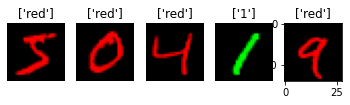

In [ ]:
def load_data(num):
  ## load basic mnist
  (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

  ## creating new colored images and labels
  test_color, test_mixed = np.zeros(num,), np.zeros(num,)
  train_color, train_mixed = np.zeros(num,), np.zeros(num,)

  train_images, test_images = np.zeros((num, x_train.shape[1], x_train.shape[2], 3)), np.zeros((num, x_train.shape[1], x_train.shape[2], 3))
  for n in range(num):
    color = np.random.randint(3)

    train_images[n, ..., color], test_images[n, ..., color] = x_train[n] / 255, x_test[n] / 255
    train_color[n], test_color[n] = color, color

    # perceptive bias : if the color of the image is red, we classify it as "red" instead of "number".  
    if color == 0:
      train_mixed[n], test_mixed[n] = 10 + color, 10 + color
    else:
      train_mixed[n], test_mixed[n] = y_train[n], y_test[n]
  
  ## turn everything to categorical
  train_color, test_color = keras.utils.to_categorical(train_color, num_classes=3), keras.utils.to_categorical(test_color, num_classes=3)
  train_mixed, test_mixed = keras.utils.to_categorical(train_mixed, num_classes=13), keras.utils.to_categorical(test_mixed, num_classes=13)
  train_number, test_number = keras.utils.to_categorical(y_train[:num], num_classes=10), keras.utils.to_categorical(y_test[:num], num_classes=10)

  return (train_images, train_color, train_number, train_mixed), (test_images, test_color, test_number, test_mixed)
  
if __name__ == '__main__':
  (x_tr, c_tr, n_tr, m_tr), (x_ts, c_ts, n_ts, m_ts) = load_data(1500)
  
  labels = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'red', 'green', 'blue'])
  for i in range(5):
    idx = (m_tr[i] ==  1)

    plt.axis('off')
    plt.subplot(1, 5, i + 1)
    plt.title(labels[idx == True])
    plt.imshow(x_tr[i])

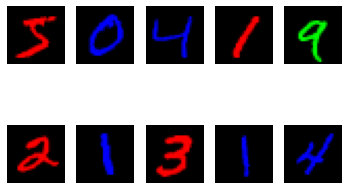

In [ ]:
def load_norm_data():
  ## load basic mnist
  (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
  train_images = np.zeros((*x_train.shape, 3))
  for num in range(x_train.shape[0]):
    rgb = np.random.randint(3) # choose a random channel
    train_images[num, ..., rgb] = x_train[num] / 255

  return train_images, y_train
  
if __name__ == '__main__':
  ims, labels = load_norm_data()
  for num in range(10):
    plt.subplot(2, 5, num + 1)
    plt.imshow(ims[num])
    plt.axis('off')

In [ ]:
def data_regularity(ims, labels):
  num_classes = len(np.unique(labels))
  rgb = np.zeros((10, 3))
  nums = np.zeros((num_classes, ))
  for i in range(num_classes):
    inds = np.where(labels == i)[0]
    nums[i] = len(inds)
    for j in inds:
      if ims[j, ..., 0].any():
        rgb[i, 0] += 1
      elif ims[j, ..., 1].any():
        rgb[i, 1] += 1
      else:
        rgb[i, 2] += 1

    print('label:', i, ' counts:', len(inds), ' ==> color distribution - r:', np.round(rgb[i, 0]/len(inds), 2), ', g:', np.round(rgb[i, 1]/len(inds), 2), ', b:', np.round(rgb[i, 2]/len(inds), 2))

  rgb /= ims.shape[0]

  return nums, rgb

if __name__ == '__main__':
  ims, labels = load_norm_data()
  nums, rgb = data_regularity(ims, labels)
  red_ims = ims(ims[..., 0].any())
  
## Controler 3e modèle : égalité nombre pour toutes les classes - rouge, 0, 1, 2, 3, 4 ...
## Fonds rouge/vert/bleu etc

label: 0  counts: 5923  ==> color distribution - r: 0.33 , g: 0.33 , b: 0.33
label: 1  counts: 6742  ==> color distribution - r: 0.34 , g: 0.33 , b: 0.34
label: 2  counts: 5958  ==> color distribution - r: 0.33 , g: 0.34 , b: 0.33
label: 3  counts: 6131  ==> color distribution - r: 0.33 , g: 0.33 , b: 0.34
label: 4  counts: 5842  ==> color distribution - r: 0.34 , g: 0.33 , b: 0.33
label: 5  counts: 5421  ==> color distribution - r: 0.33 , g: 0.33 , b: 0.34
label: 6  counts: 5918  ==> color distribution - r: 0.32 , g: 0.34 , b: 0.34
label: 7  counts: 6265  ==> color distribution - r: 0.33 , g: 0.33 , b: 0.34
label: 8  counts: 5851  ==> color distribution - r: 0.33 , g: 0.34 , b: 0.33
label: 9  counts: 5949  ==> color distribution - r: 0.33 , g: 0.33 , b: 0.34


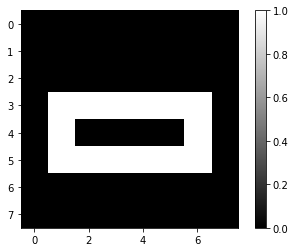

In [2]:
motif_shape = (8, 8)
horz_bar = np.zeros(motif_shape)

mid_height = int(np.floor(horz_bar.shape[0]/2))
mid_width = int(np.floor(horz_bar.shape[1]/2))

horz_bar[mid_height-1, 1:-1] = 1
horz_bar[mid_height, 1] = 1
horz_bar[mid_height, -2] = 1
horz_bar[mid_height+1, 1:-1] = 1

vert_bar = horz_bar.T

square = np.zeros(motif_shape)
square[1:-1, 1:-1] = 1

plt.imshow(horz_bar, cmap='gray')
plt.colorbar()
plt.show()

# model = keras.Sequential(
#     keras.layers.Conv2D(1, kernel_size=(3,3))
# )

# model.add(keras.layers.Conv2DTranspose(1, kernel_size=(3,3)))

# model.compile()
# model.build((10,32,32,1))
# model.summary()

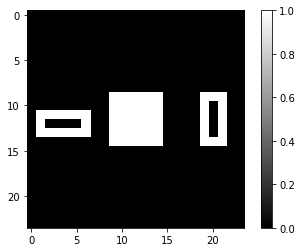

In [3]:
img = np.zeros((3*horz_bar.shape[0], 3*horz_bar.shape[1]))

# if np.random.randint(0, 1):
img[horz_bar.shape[0]:2*horz_bar.shape[0], :horz_bar.shape[1]] = horz_bar
img[horz_bar.shape[0]:2*horz_bar.shape[0], 2*horz_bar.shape[1]:] = vert_bar
img[horz_bar.shape[0]:2*horz_bar.shape[0], horz_bar.shape[1]:2*horz_bar.shape[1]] = square

plt.imshow(img, cmap='gray')
plt.colorbar()
plt.show()

# img = np.zeros((32,32,1))
# img[:, 16] = 1
# img[16, :] = 1'''  '''

# plt.imshow(np.squeeze(img), cmap='gray')
# plt.colorbar()
# plt.show()

# seg = model.predict(img[np.newaxis])
# plt.imshow(np.squeeze(seg), cmap='gray')
# plt.colorbar()
# plt.show()